## Group 3 Mobile Robotics Report

**Group Members**: Luca Engel, Marc Nassif,  Giuseppe De Carlo,  Giada Ehrlich



## Table of contents
1. [Introduction](#introduction)
2. [Setup](#setup)
3. [Implementation](#implementation)
      - 3.1 [Vision](#vision)
         -  [Marker Detection](#marker-detection)
         -  [Grayscale Conversion and Thresholding](#thresholding)
         - [2D Grid Representation](#grid-representation)
         - [Dynamic Updates](#dynamic-updates)
      - 3.2 [Global Navigation](#global-navigation)
         -  [Dijkstra Algorithm](#dijkstra-algorithm)
         -  [Path Discretization](#path-discretization)
         -  [Integration with Vision System](#integration-vision)
      - 3.3 [Motion Control](#motion-control)
         -  [Rotate](#rotate)
         -  [Move](#move)
      - 3.4 [Local Navigation](#local-navigation)
      - 3.5 [Kalman Filter](#kalman-filter)
         - [Wheel Speed Measurements](#wheel-speed-measurements)
         - [Prediction and Update Step](#prediction-update-step)
         - [Handling Orientation Jumps](#handling-orientation-jumps)
         - [Adaptability to Vision Feed Cut-Off](#adaptability-vision)
         
4. [Results](#results)
   - 4.1 [Video](#video)
   - 4.2 [Run Demo](#demo)
   
5. [References](#references)
 


   







<!-- headings -->

<a id="introduction"></a>
## 1. Introduction




In mobile robotics, fusing computer vision and sensor-based feedback is essential to establish reliable global navigation algorithms, motion control strategies, and sensor-based local obstacle avoidance to enable robots to intelligently and reliably navigate through dynamic environments. This report describes our effort to develop a solution that enables the Thymio robot to traverse a terrain containing obstacles and to reach a goal.

Our project integrates multiple technologies to improve the navigation precision. With the help of a video feed provided by a camera, computer vision is used to detect the map, the obstacles in the map, the Thymio robot, and the goal. Based on this information, a 2d grid of cells is constructed. The global navigation aspect employs the Dijkstra algorithm to calculate the shortest path from the Thymio to the goal, accounting for dynamically changing events, such as kidnapping where the Thymio or the goal are displaced. The motion control mechanism guided the Thymio along the calculated path which is discretized into intermediate points, facilitating a smooth and precise traversal. For local obstacle avoidance, the Thymio relies on its proximity sensors, allowing it to detect and navigate around obstacles not identified by the computer vision part. This ensures robust navigation, even when visual data is limited. The implementation of the Kalman filter for position and orientation estimation plays a pivotal role in this project. The filter combines information from the computer vision part and the wheel speeds of the Thymio to improve robustness of the navigation. The filter is even capable of functioning when the camera feed is obscured for a while, showing the robustness of our system.

This report details the design, implementation, and performance of our solution and shows how the combination of sensor data can drastically improve the capabilities and precision in robotic navigation.

<a id="setup"></a>
## 2. Setup 


### Libraries required: 
- NumPy
- tmdclient
- OpenCV
- FilterPy

### Method overview: 

Thymio initially reads a global map from processed images acquired through the webcam. It subsequently extracts a path through global navigation and adheres to this route unless faced with kidnapping or local navigation triggers.

The provided schema illustrates the code structure implemented for this purpose. In cases where the camera becomes obscured, the robot continues to follow the pre-defined global path planning until the camera sensing functionality is restored.

<img src="./report_images/implementation_structure.png" alt="Image Alt Text" width="400" height="400"/>

*implementation strucure*

####  Environment


Webcam  : AUKEY 1080P

Map :
- White background 
- Global obstacles: black 
- Local obstacles: small 3-dimensional objects
- Markers: ArUco Markers



<div align="center">
    <img src="./report_images/set_image.png" alt="Image Alt Text" width="300" height="400"/>
    <em>Set Up</em>
</div>

<a id="implementation"></a>
## 3. Implementation

<a id="vision"></a>
### 3.1 Vision


Our vision system forms the baseline of the Thymio's understanding of the environment. Using the OpenCV library, the map is created in multiple steps, each of which extracting information from the camera feed, allowing our program to identify markers, determine their orientation, and recognize obstacles. In the following, our procedure will be shown with the example of the following image feed:

<div align="center">
    <img src="./report_images/image_processing_images/simple_camera_feed.png" alt="Simple Camera Feed">
    <em>Unprocessed Camera Feed</em>
</div>

<a id="marker-detection"></a>
##### Marker Detection
We used OpenCV's ArUco marker detection algorithm to find the key elements and their orientation within the terrain, specifically, the Thymio robot, the goal, and the corners of the map. Based on this information, a transformation matrix is applied to the image to place the map corners into the corners of the image so that the map fills the entire video feed.

<div align="center">
    <img src="./report_images/image_processing_images/normal_feed_img.png" alt="Processed Image with Map Filling the Entire Screen">
    <em>Processed Feed with Map Filling the Screen</em>
</div>

<a id="thresholding"></a>
##### Grayscale Conversion and Thresholding
To simplify the object detection, we converted the camera feed to grayscale. As the objects are represented as black shaped, applying thresholding to the image allowed for easy extraction of their location in the environment.

<div align="center">
    <img src="./report_images/image_processing_images/binary_img.png" alt="Binary Image">
    <em>Binary Image</em>
</div>

The resulting image still contains some noise due to the black thymio sensors being detected as obstacles. This is resolved in the next step. 

<a id="grid-representation"></a>
##### 2D Grid Representation
Based on the information obtained in the previous steps, a 2D grid of cells is created. Each cell stores information about its status, indicating whether it is free, it is occupied by the Thymio (green), the goal (blue), or an obstacle. 

After conversion, the 2D grid looks as follows:

<div align="center">
    <img src="./report_images/image_processing_images/grid_map_with_islands_not_increased_object_size.png" alt="Grid Map with obstacles">
    <em>Grid Map with obstacles</em>
</div>



Here, still, the map contains the noise from the black sensors of the Thymio and the ArUco markers of which some are not entirely erased from the map. This is solved by removing all obstacles that are detected to be small islands which results in the following:

<div align="center">
    <img src="./report_images/image_processing_images/grid_map_islands_removed_not_increased.png" alt="Grid Map with Islands Removed">
    <em>Grid Map with Islands Removed</em>
</div>




Lastly, to account for the width of the Thymio, obstacles are artificially enlarged to ensure that the Thymio cannot drive too close to the obstacles. The resulting map looks as follows:

<div align="center">
    <img src="./report_images/image_processing_images/grid_map_islands_removed_objects_increased.png" alt="[Grid Map with Object Size Increased">
    <em>Grid Map with Object Size Increased</em>
</div>



<a id="dynamic-updates"></a>
##### Dynamic Updates
The grid is continuously updated with the positions of the Thymio and the goal within the map. These updates ensure that the Thymio can make informed decisions and enable recomputing the path after kidnapping events or motion control adjustments.

This part lays the groundwork for successful navigation of the Thymio robot in the terrain.

<a id="global-navigation"></a>
### 3.2 Global Navigation



Our global navigation system guides the Thymio robot throught the map by calculating the shortest path from its start location to the goal. This path is found with the Dijkstra algorithm. Similar to the vision, the navigation is also constructed in a multi-step approach.

<a id="dijkstra-algorithm"></a>
##### Dijkstra Algorithm
The shortest path is calculated using the Dijkstra algorithm. The resulting path ensures that the Thymio can navigate through the environment while avoiding obstacles and ensures that it efficiently reaches the goal.

<a id="path-discretization"></a>
##### Path Discretization
To have the Thymio drive more smoothly, the computed path is discretized into a series of fewer cells. Each cell represents a direction change in the path. The Thymio receives these cells as intermediate goals allowing a more natural movement along the path and decreasing the number of sudden direction changes. The resulting path is marked red in the map and the direction changes purple. With this addition, the grid image looks as follows:

<div align="center">
    <img src="./report_images/image_processing_images/grid_map_with_path.png" alt="[Grid Map Marked with Path and Direction Changes">
    <em>Grid Map Marked with Path and Direction Changes</em>
</div>


<a id="integration-vision"></a>
##### Integration with Vision System
Based on the information received from the vision system, the path is calculated and obstacles can be avoided. Additionally, kidnapping of the thymio and the goal can be handled. Whenever such a kidnapping occurs, the path is recomputed so that the goal can be reached.


The combination of the Dijkstra algorithm, path discretization, and intermediate goal navigation, ensures a smooth and fast traversal of the map, even accounting for sudden events such as kidnapping.

<a id="motion-control"></a>
### 3.3 Motion Control

The motion control is designed to manage the speed and the direction of the Thymio. It was defined as a class to perform the basic movements of the robot. The class is used during the entire process, except when the Thymio needs to avoid an obstacle, and in this case, the *Local Navigation* becomes active.
 
The motion control handles 3 states of the robot's movement:
* **STOP**: Halts the robot to move during the process or when it reaches the goal.
* **ROTATE**: Prior moving to the next point, the Thymio aligns is direction to face it. Once done, the robot transits in MOVE mode.
* **MOVE**: When the Thymio has the confirmation that it is aligned, it will begin moving towards the next point. This process is regulated by a PI controller to adjust the Thymio's trajectory.
     
Now we will describe the main movement of our robot, the ROTATE and the MOVE and describe how they operate.
  
<a id="rotate"></a>   
##### ROTATE

<div align="center">
    <img src="./report_images/BOMR_Rotation.PNG" alt="ROTATE mode illustration">
    <em>ROTATE mode illustration</em>
</div>


As we observe in the picture, the ROTATE mode calculates the error between the desired angle and the Thymio's actual angle. Once the calculation done, the Thymio receives the sorthest path to align itslef with the desired angle and will rotate on its axis to start the correction. When the Thymio has reached the correct angle, the camera signals it and the Thymio will execute the MOVE command towards the next point.

<a id="move"></a> 
##### MOVE
<div align="center">
    <img src="./report_images/BOMR_PI.PNG" alt="MOVE Mode illustration">
    <em>MOVE Mode illustration</em>
</div>


After aligning with the desired angle, the PI controller handles the movement towards the next point. During it, the regulation works to maintain the Thymio's direction in the threshold angle. When the Thymio is in the threshold zone, *the green cone*, both wheels rotate at the same velocity. When the Thymio is out of the cone, the PI controller corrects the direction by increasing the speed of one wheel and decreasing the speed of the other one. The regulation works until the error is inside the threshold zone, avoiding oscillation around the desired angle.
     
Like explained before, the PI controller is performing during all the robot's movement, except when it enters in obstacle avoidance who is managed by the *Local Navigation*. The tuning of our regulator, *Kp* and *Ki*, was tuned in an experimental way. We observed how the robot was correcting its error, with small gains, and progressively increased the values of our gains to achieve a smooth and dynamic correction. Finally, we obtanied acceptable results with a *Kp = 3* and a *Ki = 0.2*.

We implemented a parameter, called *sum_error_max* to avoid wheel drift during the movement. The maximum value was determined by an experimental way, similar to the regulator parameters.


##### Program of the movement
Finally, you can observe, with the next schematic, how our Thymio's motion control is configure to perform its mission.
<div align="center">
    <img src="./report_images/BOMR_MotionStep.PNG" alt="Schematic of the Movement">
    <em>Schematic of the Movement</em>
</div>




<a id="local-navigation"></a>
### 3.4 Local Navigation


In our project, the Thymio robot's local navigation is intricately linked to the status of its proximity sensors. Since, in our project, the robot does not move backwards, the sensors at the back of the Thymio are ignored. At the core of this functionality is an instance of the `LocalNavigation` class, initialized at program startup, responsible for tracking relevant variables associated with local navigation.

During each iteration of the primary while True loop, the proximity sensors values are pulled, and they are sent to the `judge_severity()` method. This method, determines the danger level for each sensor, which increases when obstacles are nearer. The maximum danger level among these sensors is then assigned to the `danger_state` attribute within the local navigation instance.

The DangerState enum encapsulates threshold values, which have been fine-tuned through experimentation to reflect different danger levels. In cases where the Thymio finds itself in an unsafe state, global navigation is temporarily suspended and a status variable (`local_nav.state`) is modified to track in which phase of local navigation the Thymio is. 


```python
def judge_severity(self):
        """
        Updates the danger_state of the LocalNavigation object and returns it
        """
        self.danger_state = DangerState.SAFE
        #Do no handle the back sensors, since Thymio does not reverse in Global Nav
        for i in range(5):
            if (self.prox_horizontal[i] > SensorThresh.STOP_THRESH.value):
                self.danger_state = DangerState.STOP
                return self.danger_state    #If any sensor is at STOP, we do not overwrite it
            elif (self.prox_horizontal[i] > SensorThresh.WARN_THRESH.value):
                self.danger_state = DangerState.WARN
        return self.danger_state
```

Local Navigation unfolds in two distinct phases:

- Rotation:
In this phase, the Thymio robot determines a turning direction based on the global path's next turn direction. The objective is to navigate along the outer edge of the turn, a strategy particularly effective when following paths generated by Dijkstra navigation. As these paths tend to adhere closely to global obstacles, adopting an outward trajectory facilitates global obstacle avoidance.

    Once the turning direction is determined, the Thymio initiates a rotational movement in place. This rotation persists until the robot no longer detects obstacles in its proximity. Importantly, even after achieving clearance, the robot continues to rotate for a few additional iterations. This deliberate extension adds a margin of safety, preventing the Thymio from executing a turn too close to an obstacle and potentially colliding with it.

```python
def determine_turn_dir(self, dir_changes, next_dir_change_idx):
        """
        Determines turn direction for circling an object, based on the Dijktra path.
        Since the path tends to stick to object, circling outside the next turn will
        avoid the Local obstacle without crossing a global obstacle.
        Updates turn_dir, to be called in turn()
        """
        previous_cell = np.array(dir_changes[next_dir_change_idx-1])
        current_cell = np.array(dir_changes[next_dir_change_idx])
        next_cell = np.array(dir_changes[next_dir_change_idx+1])

        current_vector = current_cell - previous_cell
        next_vector = next_cell - current_cell

        orientation_current_v = rotation_nextpoint(current_vector)
        orientation_next_v = rotation_nextpoint(next_vector)

        orientation_difference = (orientation_next_v - orientation_current_v)%360
        #We have now the turn angle of the next turn in the path, determine which way to turn to circle wide around it

        if orientation_difference < 180:
            self.turn_dir = 'r'
        else:
            self.turn_dir = 'l'
```

- Circling:
With the Thymio's orientation now firmly established through the preceding rotation phase, the robot enters the circling phase. In this stage, forward motion is initiated with a subtle offset between the left and right motors, enabling the Thymio to trace a wide circle around the detected obstacle.

    If an obstacle is detected during this circling motion, the robot seamlessly transitions back to the turning phase, reverting to the initially chosen turning direction. This strategic continuity allows the Thymio to gracefully navigate around elongated obstacles by tracing circles along their edge.
    The circling phase concludes when the Thymio reconnects with the Global Navigation path, which is bound to happen, as pathfinding is designed to create non-looping paths. Once the Thymio detects its return to the path, it recomputes the remaining checkpoints (turning points), selects the next one in line, and gracefully relinquishes control back to the Global Navigation module.



It therefore acts as a simple Finite State Machine, illustrated in the image below:

<div align="center">
    <img src="./report_images/image_processing_images/local_navigation_fsm.png">
    <em>Local Navigation Finite State Machine illustration</em>
</div>



The START State allows Global Navigation to steer the Thymio freely, so long as no obstacle is detected by the sensors, which will drive a state change.

If the Thymio's marker is obscured during Local Navigation, it will still move using the Kalman Filter to estimate position. Once sight is restored, if the Thymio's position has changed too much, the Thymio will recompute the optimal path and use that to move. This is necessary, as it allows us to kidnap the Thymio during Local Navigation, and have it handle well. This situation also happens in the case of tall obstacles, and typically the Thymio's new path will not cross the obstacle, but even if it does, circling will work well as it will not go back behind the obstacle.

*The counters on the Thymio's rotation are staggered by Global Navigation's `wait_for_variables`. While this is not exact, we do not need an exact delay as we are not aiming for perfect navigation, we just need a little bit of slack in this application!

The local navigation path is illustrated below:

<div align="center">
    <img src="./report_images/image_processing_images/grid_map_with_local_avoidance.png">
    <em>Illustration of Local Avoidance Path</em>
</div>

The Thymio detects the object (here in blue) and deviates from the Global Path (in red), choosing to go on the *outside* of the path's turn, thus drawing a circle, here in orange.

Please note however that this image is never generated, as the camera and the computer are never aware of the local obstacle, this is only an illustration of a path possibly taken during local navigation.

<a id="kalman-filter"></a>
### 3.5 Kalman Filter

Our Kalman filter implementation serves a critical role in the position and orientation estimation of our Thymio. It uses the KalmanFilter library of pythons filterpy package and combines the wheel motor speed of the Thymio with the information provided by the computer vision part to increase accuracy.

<a id="wheel-speed-measurements"></a>
##### Wheel Speed Measurements
The wheel speed measurements are used for both estimating the position and orientation of the Thymio. A refinement was introduced by incorporating a max-min constraint, to mitigate the impact of noise on the speed sensors. This addition serves to limit the potential noise-induced variations in the sensor readings, contributing to a more stable and reliable interpretation of the Thymio robot's speed information. To predict the new orientation, the angular velocity is calculated based on the difference of wheel speeds and a baseline minimum period for a 360° turn of the Thymio. 

```python
# WHEEL_MIN_SPEED <= v <= WHEEL_MAX_SPEED
v = (left_wheel_speed + right_wheel_speed) / 2.0

right_wheel_speed = max(min(right_wheel_speed, WHEEL_MAX_SPEED), WHEEL_MIN_SPEED)
left_wheel_speed = max(min(left_wheel_speed, WHEEL_MAX_SPEED), WHEEL_MIN_SPEED)

period = 0
if abs(right_wheel_speed - left_wheel_speed) > 0.5:  # avoid division by 0 and large values
    period = ((2*WHEEL_MAX_SPEED) / (right_wheel_speed - left_wheel_speed)) * MIN_THYMIO_360_TURN_PERIOD  # positive sense is counterclockwise
    w = 0
    if period != 0:
        w = - 2 * np.pi / period
```

##### Camera input
As the camera input already is provided in grid coordinates by the computer vision, there is no additional processing needed for it.

<a id="prediction-update-step"></a>
##### Prediction and Update Step
We use the wheel speed measurements to perform the prediction step of the Kalman filter and use the computer vision information in the update method. With the combination of these two informations, the Kalman filter provides an accurate estimation of the position and orientation of the Thymio robot.

<a id="handling-orientation-jumps"></a>
 ##### Handling Orientation Jumps
As the provided orientation input from our computer vision module is a float between 0 and 2π, depending on the Thymio's orientation, there may be jumps in the estimated orientation from 0 to 2π and vice versa. This leads to large jumps in the overall estimation of the orientation. To combat that, we do not limit the predicted orientation to [0, 2π] but let it be any number and scale using the mod operation only when the navigation part accesses it. This dramatically improved the orientation estimation of our filter.

<a id="adaptability-vision"></a>
##### Adaptability to Vision Feed Cut-Off
Whenever the camera feed is unavailable, the Kalman filter continues to estimate the postition and orientation based solely on the predictions derived from the wheel speed measurements. This allows the Thymio to maintain knowledge of its position and orientation even when external measurements are unavailable

The Kalman filter's ability to combine information from wheel speed measurements and vision data drastically increases the robustness of our navigation and even allows for accurate driving when no computer vision data is available.


##### Details in the choice of matrices 
the matrices for the kalman filter are the following:
- F = State Transition Matrix
- Q = Process Noise Covariance
- H = Measurement Function  
- R =  Measurement Noise Covariance

\begin{aligned}
& F=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right] \quad Q=\left[\begin{array}{llll}
\sigma_{Qx}^2 & 0 & 0 & 0 \\
0 & \sigma_{Qy}^2 & 0 & 0 \\
0 & 0 & \sigma_{Q\theta}^2 & 0 \\
0 & 0 & 0 & 0
\end{array}\right]  \\
& H=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right] 
\quad R=\left[\begin{array}{llll}
\sigma_{Rx}^2 & 0 & 0 & 0 \\
0 & \sigma_{Ry}^2 & 0 & 0 \\
0 & 0 & \sigma_{R\theta}^2 & 0 \\
0 & 0 & 0 & 0.1
\end{array}\right] 
\end{aligned}


The variances were determined through experimental considerations. The best values were found to be:
> $\sigma_{Qx}^2 = \sigma_{Qy}^2 = 0.001, \ \sigma_{Q\theta}^2 = 1$

> $\sigma_{Rx}^2 = \sigma_{Ry}^2 = \sigma_{R\theta}^2 = 0.1$
 

Each parameter was tuned seperately under the assumption that there is no correlation between the parameters.

<a id="results"></a>
### 4. Results


The image processing and vision components proved to be highly robust, consistently delivering accurate results in detecting obstacles, the Thymio robot, and the goal. The implementation of live camera feed utilizing ArUco markers was particularly precise, even enabling successful recovery from simulated kidnapping scenarios.

Concerning navigation, the path derived through the Dijkstra algorithm demonstrated sufficient optimization, allowing the robot to traverse from the starting point to the goal position efficiently. The motion control mechanisms effectively ensured that the Thymio adhered to the designated path.


The biggest problem that we encountered was ..


<a id="video"></a>
##### Video: 

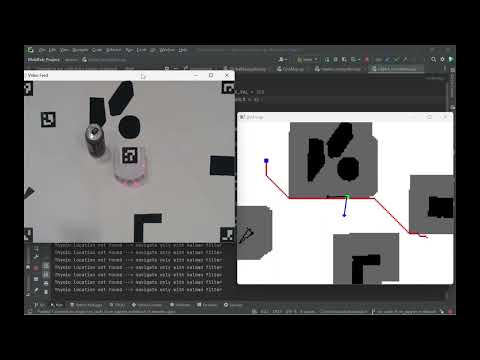

In [14]:
from IPython.display import YouTubeVideo
video_height_width_ratio = 1200 / 1920
width = 700
YouTubeVideo('gpMigWjB38A',width=width, height=video_height_width_ratio * width)

<a id="demo"></a>
# Run Demo

In [1]:
%run ./Main.py

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

<a id="references"></a>
### Resources 

- OpenCv ArUco Markers: https://docs.opencv.org/3.2.0/d5/dae/tutorial_aruco_detection.html
- ArUco Marker Generation: https://chev.me/arucogen/
- Kalman Filter: https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html

